In [2]:
from sqlalchemy import create_engine
from pandasql import sqldf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as st
from mlxtend.plotting import plot_decision_regions
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

from collections import OrderedDict, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, f1_score 
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
# make prettier plots
%config InlineBackend.figure_format = 'svg'

In [4]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    # Here, we select a sample (`choice`) from all possible unique users
    total_users = df['id'].unique()
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['id'].isin(test_users)]
    df_te = df[df['id'].isin(test_users)] 

    y_tr, y_te = df_tr['success'].astype('category'), df_te['success'].astype('category')
    X_tr = df_tr.drop(['id','success'],axis=1) 
    X_te = df_te.drop(['id','success'],axis=1)
    
    print(f"Actual Test Size: {y_te.shape[0] / df.shape[0]:0.4}")
    
    return X_tr, X_te, y_tr, y_te

In [6]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)
    plt.plot(fpr, tpr, marker='o')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 4)}");

In [3]:
cmp_all= pd.read_csv('cmp1.csv')

In [5]:
X_tr_v, X_te, y_tr_v, y_te = get_user_split_data(cmp_all)
X_tr, X_v, y_tr, y_v=train_test_split(X_tr_v, y_tr_v, test_size=0.3, random_state=41)

Actual Test Size: 0.2


# Multiple Logistic Regression

In [13]:
lm = LogisticRegression()
lm.fit(X_tr, y_tr)
print("training score: {}".format(lm.score(X_tr, y_tr)))
print("testing score: {}".format(lm.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, lm.predict(X_v)))
print(classification_report(y_v, lm.predict(X_v)))

training score: 0.8587597489062203
testing score: 0.8596393897364771
confusion_matrix: 
 [[15463    24]
 [ 2506    32]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     15487
           1       0.57      0.01      0.02      2538

    accuracy                           0.86     18025
   macro avg       0.72      0.51      0.47     18025
weighted avg       0.82      0.86      0.80     18025



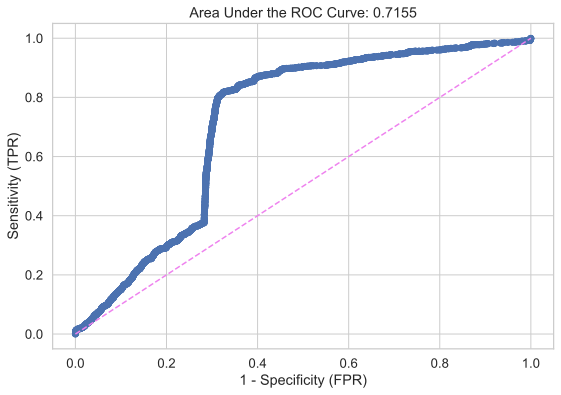

In [14]:
proba=lm.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

# Multiple Logistic Regression (Scaler)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_tr)
y_train = y_tr
X_test = scaler.transform(X_v)

In [17]:
lm1 = LogisticRegression()
lm1.fit(X_train, y_train)
print("training score: {}".format(lm1.score(X_train, y_train)))
print("testing score: {}".format(lm1.score(X_test, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, lm.predict(X_test)))
print(classification_report(y_v, lm1.predict(X_test)))

training score: 0.8765217804831653
testing score: 0.876005547850208
confusion_matrix: 
 [[10155  5332]
 [  495  2043]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     15487
           1       0.62      0.30      0.40      2538

    accuracy                           0.88     18025
   macro avg       0.76      0.63      0.67     18025
weighted avg       0.86      0.88      0.86     18025



/Users/yuwenhuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


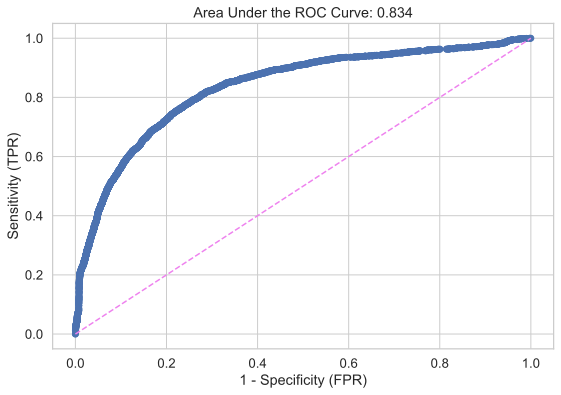

In [18]:
proba=lm1.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

# K Neighbors Classifier

In [19]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_tr, y_tr)
print("training score: {}".format(knn.score(X_tr, y_tr)))
print("testing score: {}".format(knn.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, knn.predict(X_v)))
print(classification_report(y_v, knn.predict(X_v)))

training score: 0.9008464903937607
testing score: 0.8909847434119279
confusion_matrix: 
 [[15102   385]
 [ 1580   958]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     15487
           1       0.71      0.38      0.49      2538

    accuracy                           0.89     18025
   macro avg       0.81      0.68      0.72     18025
weighted avg       0.88      0.89      0.88     18025



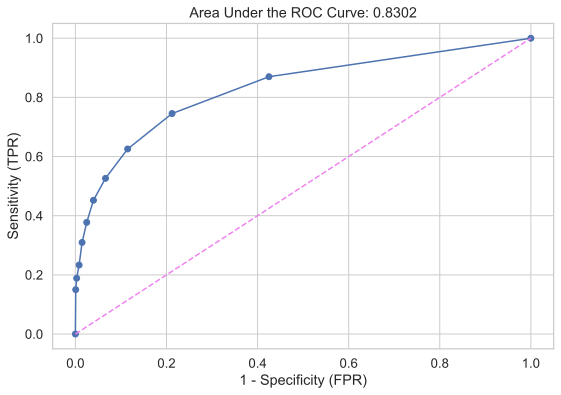

In [20]:
proba=knn.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

# Naive Bayes - Gaussian

In [21]:
nb = GaussianNB()
nb.fit(X_tr, y_tr)
print("training score: {}".format(nb.score(X_tr, y_tr)))
print("testing score: {}".format(nb.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, nb.predict(X_v)))
print(classification_report(y_v, nb.predict(X_v)))

training score: 0.8557637435799886
testing score: 0.8554230235783634
confusion_matrix: 
 [[15295   192]
 [ 2414   124]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     15487
           1       0.39      0.05      0.09      2538

    accuracy                           0.86     18025
   macro avg       0.63      0.52      0.50     18025
weighted avg       0.80      0.86      0.80     18025



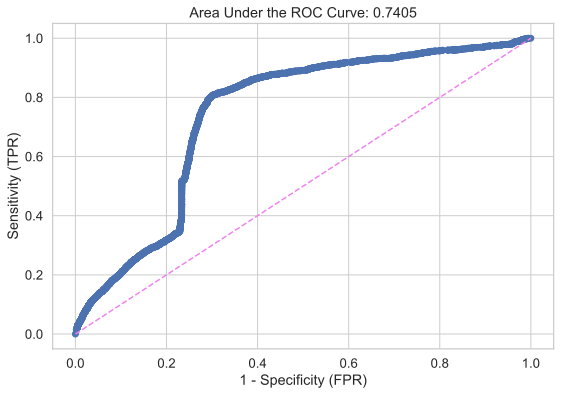

In [22]:
proba=nb.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

# Naive Bayes - Multinomial

In [23]:
nb1 = MultinomialNB()
nb1.fit(X_tr, y_tr)
print("training score: {}".format(nb1.score(X_tr, y_tr)))
print("testing score: {}".format(nb1.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, nb1.predict(X_v)))
print(classification_report(y_v, nb1.predict(X_v)))

training score: 0.8233070192124786
testing score: 0.8238002773925104
confusion_matrix: 
 [[14348  1139]
 [ 2037   501]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     15487
           1       0.31      0.20      0.24      2538

    accuracy                           0.82     18025
   macro avg       0.59      0.56      0.57     18025
weighted avg       0.80      0.82      0.81     18025



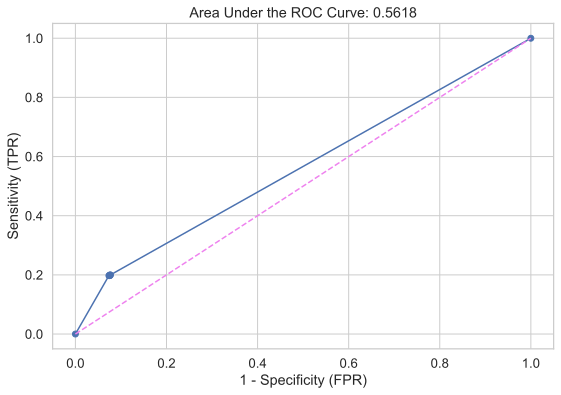

In [24]:
proba=nb1.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)